## CLUSTERING ---> CUSTOMER SEGMENTATION

The goal in this kernel is to classify our clients into several groups with similar behaviours. This technique is known as Clustering. Some customers have similar behaviour or characteristics and we are going to develop an algorithm that is able to determine these similarities.

In [1]:
#Loading basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Nice plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("magma", n_colors=10))

#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

#Several outputs in the same code cell
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

#Ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

#Setting a seed for random steps
np.random.seed(0) 


### LOAD THE DATA

The data used in this kernel is the 'Mall Customer Segmentation Data' of Kaggle. The fields in the dataset are: ID of customer, age, gender, income and spending score. This last concept, spending score, is the one we will be focused on. We want to determine hidden patterns in our data that help us to increase the 'spending score' of our customers. So the hidden patterns found have to be related to the 'spending score' field.

In [2]:
#Loading the data

data=pd.read_csv(r'T:\01. EMPRESARIAL\03.ARANTXA\MIS COSAS\MIS CURSOS\DATA_SCIENCE\PROYECTOS_Data\MACHINE LEARNING\CLUSTERING\Customer segmentation\Mall_Customers.csv')

In [94]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#Statistics abour our data

data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000,200.000,200.000,200.000
mean,100.500,38.850,60.560,50.200
std,57.879,13.969,26.265,25.824
min,1.000,18.000,15.000,1.000
25%,50.750,28.750,41.500,34.750
50%,100.500,36.000,61.500,50.000
75%,150.250,49.000,78.000,73.000
max,200.000,70.000,137.000,99.000


We can see we have a small dataset in this kernel, only 200 rows and 5 features. Anyway is enough to perform a clustering algorithm. 

### EXPLORATORY DATA ANALYSIS

Let´s make some plots to see the distribution of each field. We will make bar plots for categorical variables and histograms for numerical variables. So, first we will subdivided the features into these two groups.

In [13]:
#Numerical and categorical variables

numeric=data.select_dtypes(exclude='O')
categorical=data.select_dtypes('O')

numeric.shape
categorical.shape

(200, 4)

(200, 1)

We have 4 numeric variables and only 1 categorical feature. Let´s make some plots. First, the number of customers based on Gender. It seems we have more female customers.

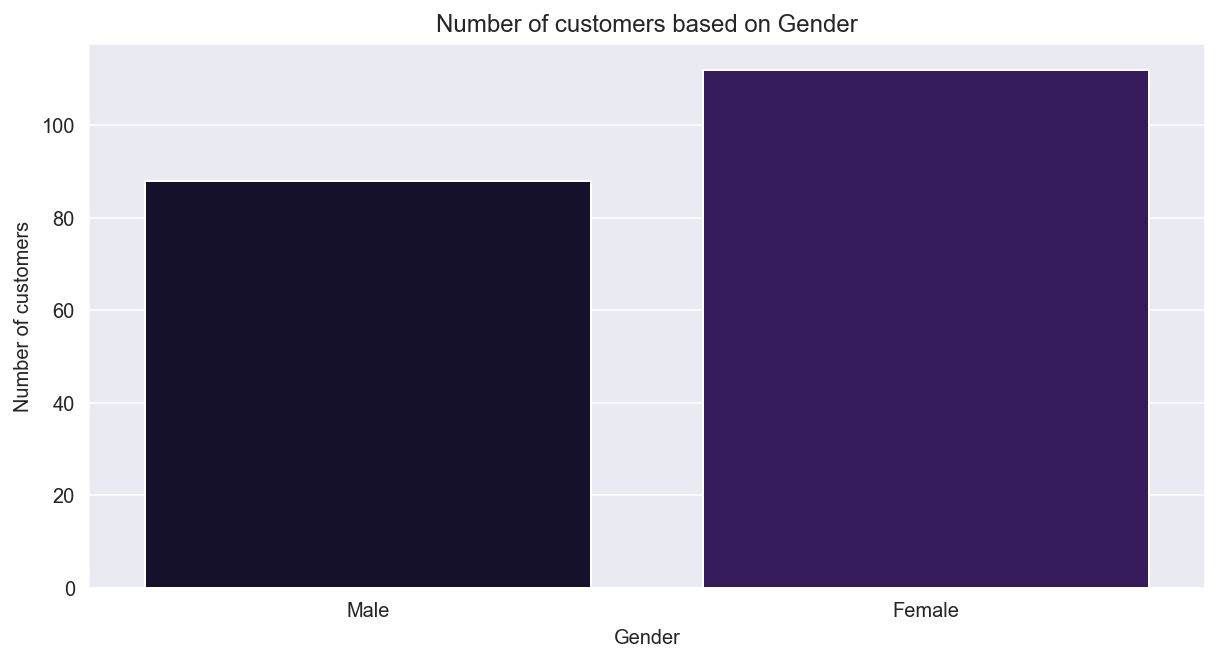

In [20]:
#Number of customers based on gender

plt.figure(figsize=(10,5))
sns.countplot(categorical['Gender'])
plt.ylabel('Number of customers')
plt.title('Number of customers based on Gender');

If we plot the annual income distribution we see that our main customers have an annual income less than 88000$, and the proportion of male and female is equivalent. For higher annual incomes, our main customers are female, but our target decreases consistenly for this range of salaries.

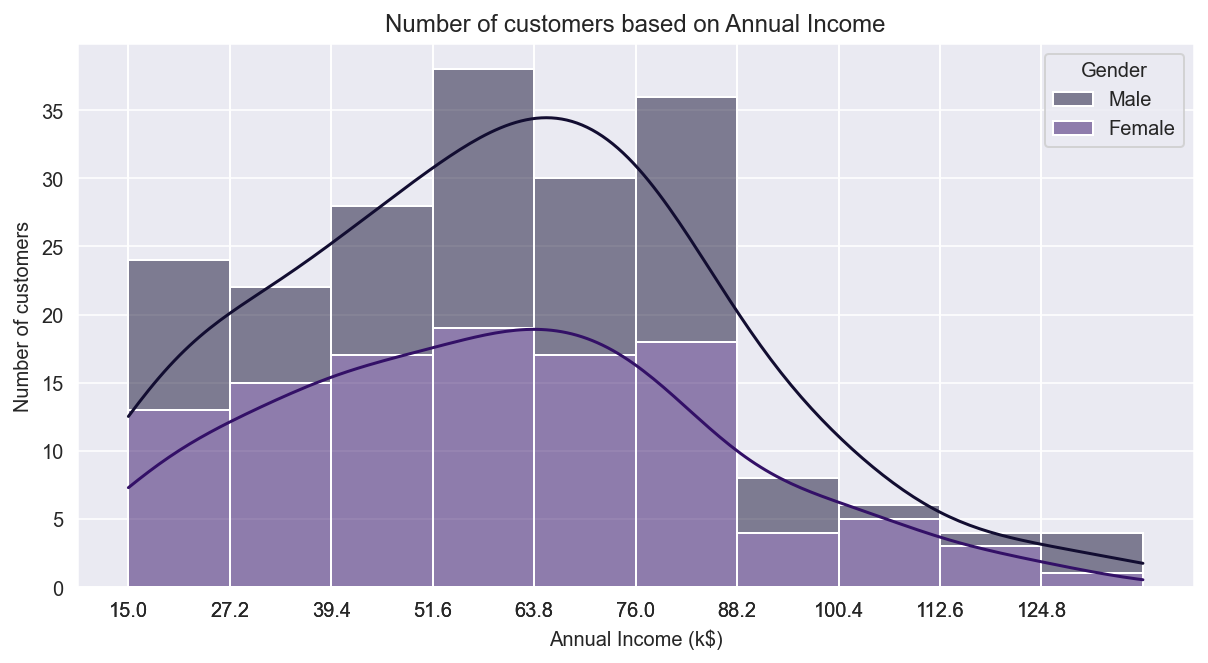

In [49]:
#Annual income distribution

plt.figure(figsize=(10,5))
ax=sns.histplot(data, x='Annual Income (k$)', stat='count', kde=True, hue='Gender', multiple='stack')
#mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
mids = [rect.get_x() for rect in ax.patches]
ax.set_xticks(mids)
plt.ylabel('Number of customers')
plt.title('Number of customers based on Annual Income');

Our main customers are between 18 and 40 years old. Also between 44 and 50.

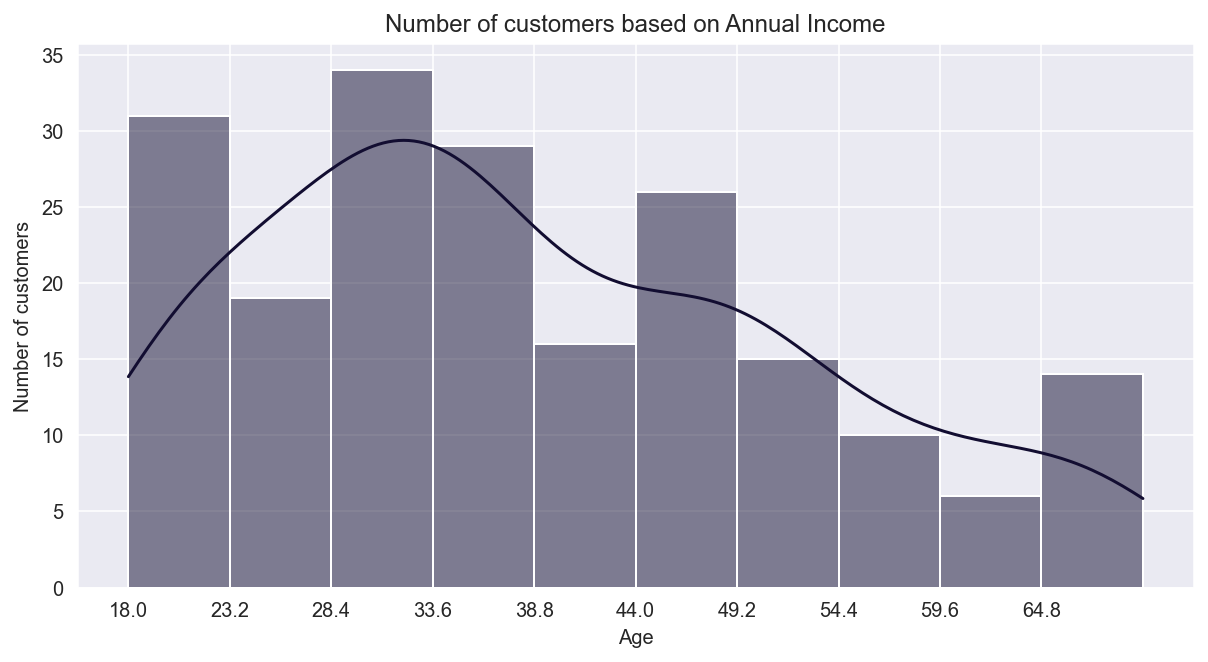

In [58]:
#Age of customers

plt.figure(figsize=(10,5))
ax=sns.histplot(data, x='Age', stat='count', kde=True, multiple='stack', bins=10)
mids = [rect.get_x() for rect in ax.patches]
ax.set_xticks(mids)
plt.ylabel('Number of customers')
plt.title('Number of customers based on Annual Income');

We can appreciate than 33% of our customers have a medium score in spending and a near 28% a high score. So, a 50% of our customers have no bad values for spending score.

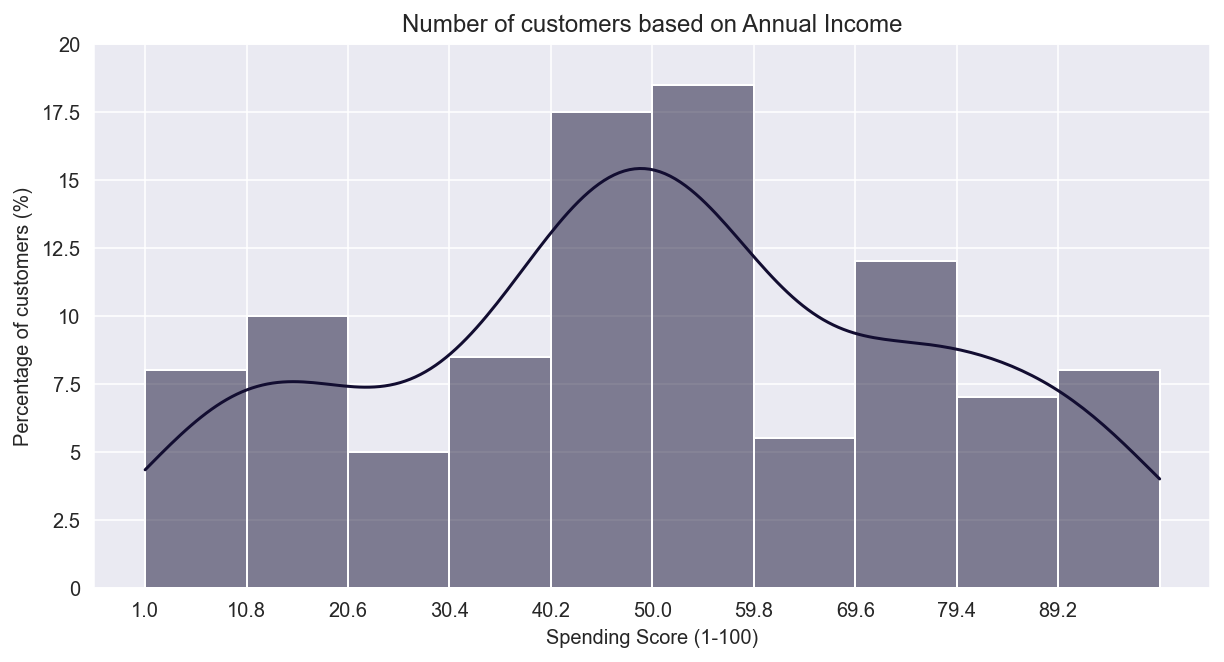

In [89]:
#Spending Score

plt.figure(figsize=(10,5))
ax=sns.histplot(data, x='Spending Score (1-100)', stat='probability', kde=True, bins=10)
#mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
mids = [rect.get_x() for rect in ax.patches]
ax.set_xticks(mids)
ax.set_yticks([0,0.025,0.05,0.075,0.1,0.125,0.150,0.175,0.2], [0,2.5,5,7.5,10,12.5,15,17.5,20])
plt.ylabel('Percentage of customers (%)')
plt.title('Number of customers based on Annual Income');

Now, analyzing the spending score based on customers Gender:

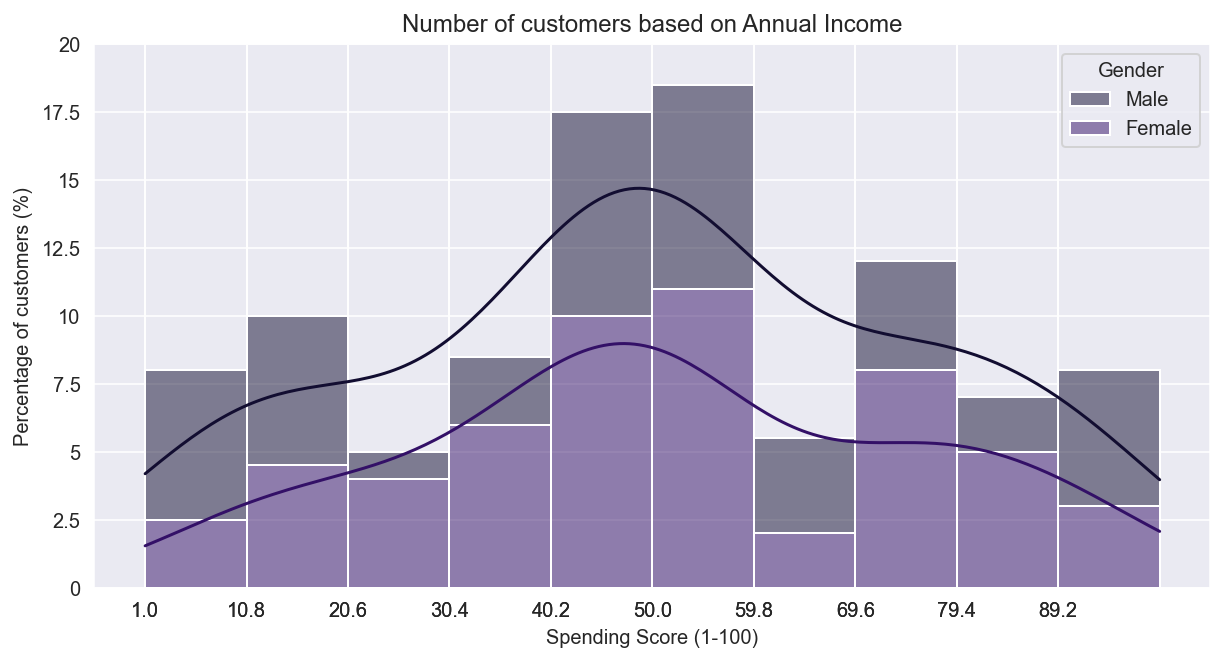

In [92]:
#Spending Score based on Customer Gender

plt.figure(figsize=(10,5))
ax=sns.histplot(data, x='Spending Score (1-100)', stat='probability', kde=True, bins=10, hue='Gender', multiple='stack')
mids = [rect.get_x() for rect in ax.patches]
ax.set_xticks(mids)
ax.set_yticks([0,0.025,0.05,0.075,0.1,0.125,0.150,0.175,0.2], [0,2.5,5,7.5,10,12.5,15,17.5,20])
plt.ylabel('Percentage of customers (%)')
plt.title('Number of customers based on Annual Income');

Now, let´s analyze the spending score based on customers Age. As Age is a continuous feature in our dataset, we cannot pass it directly to the 'hue' parameter of seaborn. We are going to make bining over Age feature for this purpose.

In [3]:
#Define a new feature for transforming Age into a categorical feature.

dict_={1:'18-25', 2:'25-35', 3:'35:45', 4:'45:55', 5:'55-70'}
age_bins=[]
for i in data['Age']:
    if i <=25:
        age_bin=1
    elif i<=35:
        age_bin=2
    elif i<=45:
        age_bin=3
    elif i<=55:
        age_bin=4
    else:
        age_bin=5
    age_bins.append(age_bin)

data['Age_bin']=age_bins
data['Age_bin']=data['Age_bin'].map(dict_)

In [108]:
#Let´s take a look to our new column

data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_bin
0,1,Male,19,15,39,18-25
1,2,Male,21,15,81,18-25
2,3,Female,20,16,6,18-25
3,4,Female,23,16,77,18-25
4,5,Female,31,17,40,25-35


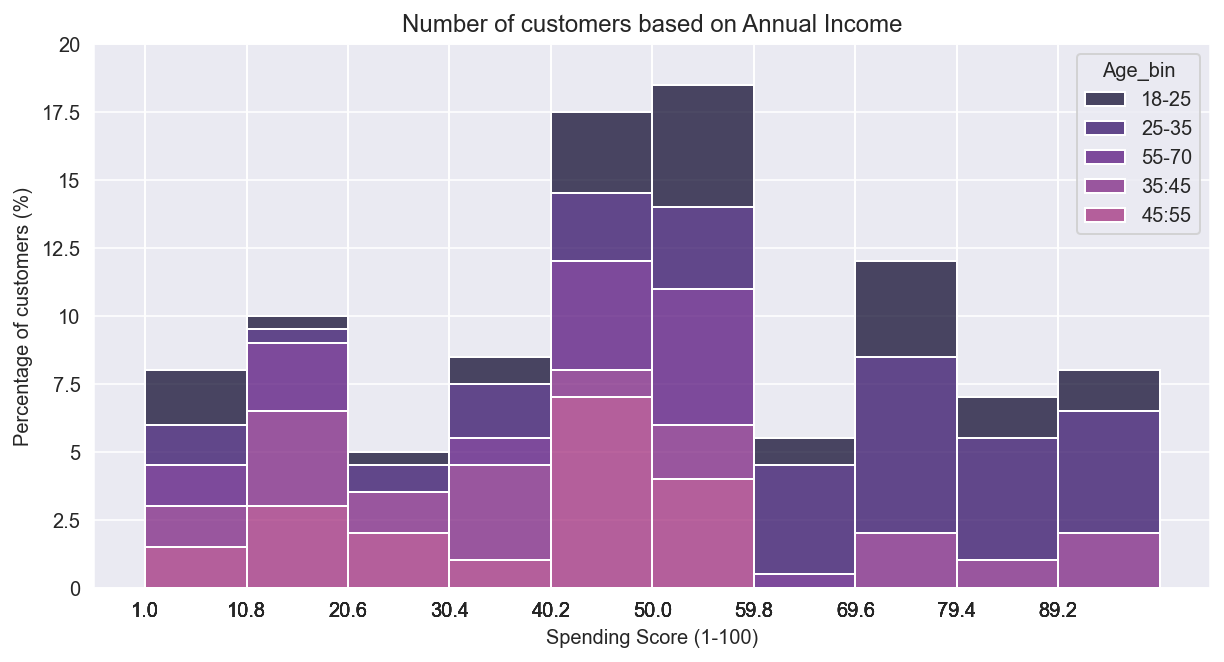

In [110]:
#Spending Score based on Customer Age

plt.figure(figsize=(10,5))
ax=sns.histplot(data, x='Spending Score (1-100)', stat='probability', bins=10, hue='Age_bin', multiple='stack')
mids = [rect.get_x() for rect in ax.patches]
ax.set_xticks(mids)
ax.set_yticks([0,0.025,0.05,0.075,0.1,0.125,0.150,0.175,0.2], [0,2.5,5,7.5,10,12.5,15,17.5,20])
plt.ylabel('Percentage of customers (%)')
plt.title('Number of customers based on Annual Income');

It seems that in the group of most spending score customers the customers between 25 and 35 years are the more relevant. Also the group between 45 and 55 is relevant.

### SCATTER PLOTS

Scatter plots is also a good way to know the relationship between two features. In this case we will analyze the relation between numerical features, excluding 'ID' that does not provide any useful information.

In [4]:
df=data.drop(['CustomerID', 'Gender', 'Age_bin'], axis=1)

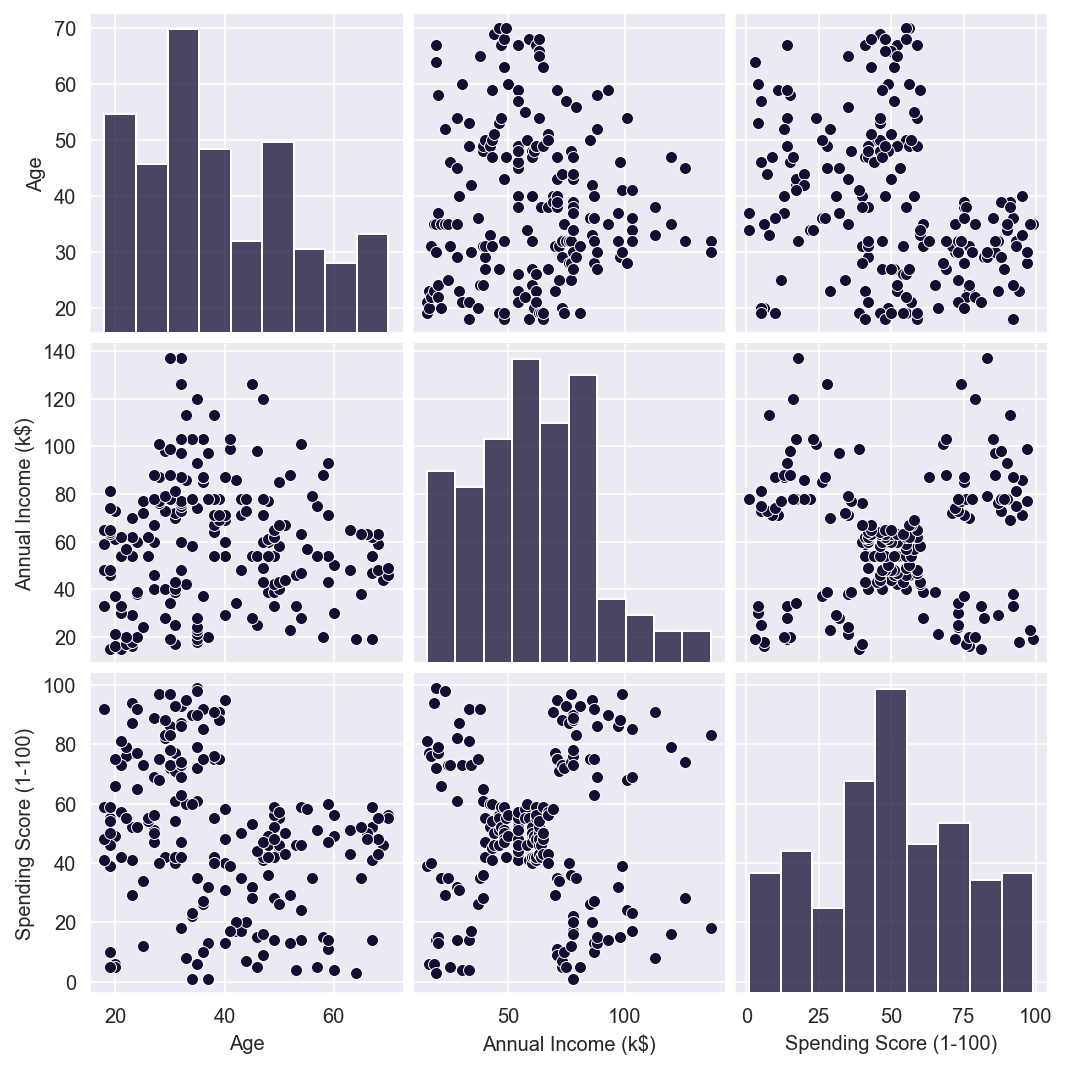

In [114]:
#Scatter plot

sns.pairplot(df);

### CLUSTERING

Now that we have already performed a previous analysis on our data, we can develop a clustering algorithm to search for similar patterns in our data. This could be reached using K-means algorithm. We will begin with this one, but will compare with other techniques later.

The metrics to validate the model will be inertia and silhouette_score. Inertia is a metric which calculates the sum of squared distances of each data point to its nearest centroid. Silhouette_score compares the distance between a data point and other data points in the same cluster with the distance of this point with other data points in the closest cluster.

KMeans algorithm subdivides the data points into groups, defining a label for each group. So, each data point is assigned to a group with a label, and a centroid is calculated. The centroid is the center of a cluster, so it is a location that is supposed to be equidistant from data points belonging the cluster. Each time a new data point is added to a cluster, the centroid is re-calculated.

As we have to study the behaviour of customers with respect the spending score (the feature of our interest), we can think about performing a clustering of each independent variable with this one and see the individual behaviour, or we can study the influence of all together. We can do both things and compare results.

#### SCALING DATA

Clustering methods are based in point distances for calculating means, medians and so on. So one important point before performing the training of the data is to standardize our data or transforming the data to a Z-score value. Nevertheless it depends on the data we are working on, in this case, we can see the scale of our variables is almost the same, unless they represent very different things. So standardize our data in this situation will not help too much to the convergence neither the accuracy during the clustering.

#### CLUSTERING WITH ALL THE FEATURES

As we are going to develop the same steps for clustering several times, we can define a custom function to do the clustering validation. This function will take as inputs the dataframe and the number of clusters we want to consider, and will output the label and centroid for each data point and also the metrics used for validation.

In [5]:
#Import libraries and define custom function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def KMeans_Clustering(dataframe, k):
    KMeans_model=KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42, algorithm='elkan')
    KMeans_model.fit(dataframe)
    
    centroids=KMeans_model.cluster_centers_
    label=KMeans_model.labels_
    
    inertia=KMeans_model.inertia_
    silhouette=silhouette_score(dataframe, label)
    
    return centroids, label, inertia, silhouette


As we are considering the full dataset to perform clustering, if we want to make some 2D plots after clustering we need to convert the dataframe into 2D data. We can perform this using T-SNE.

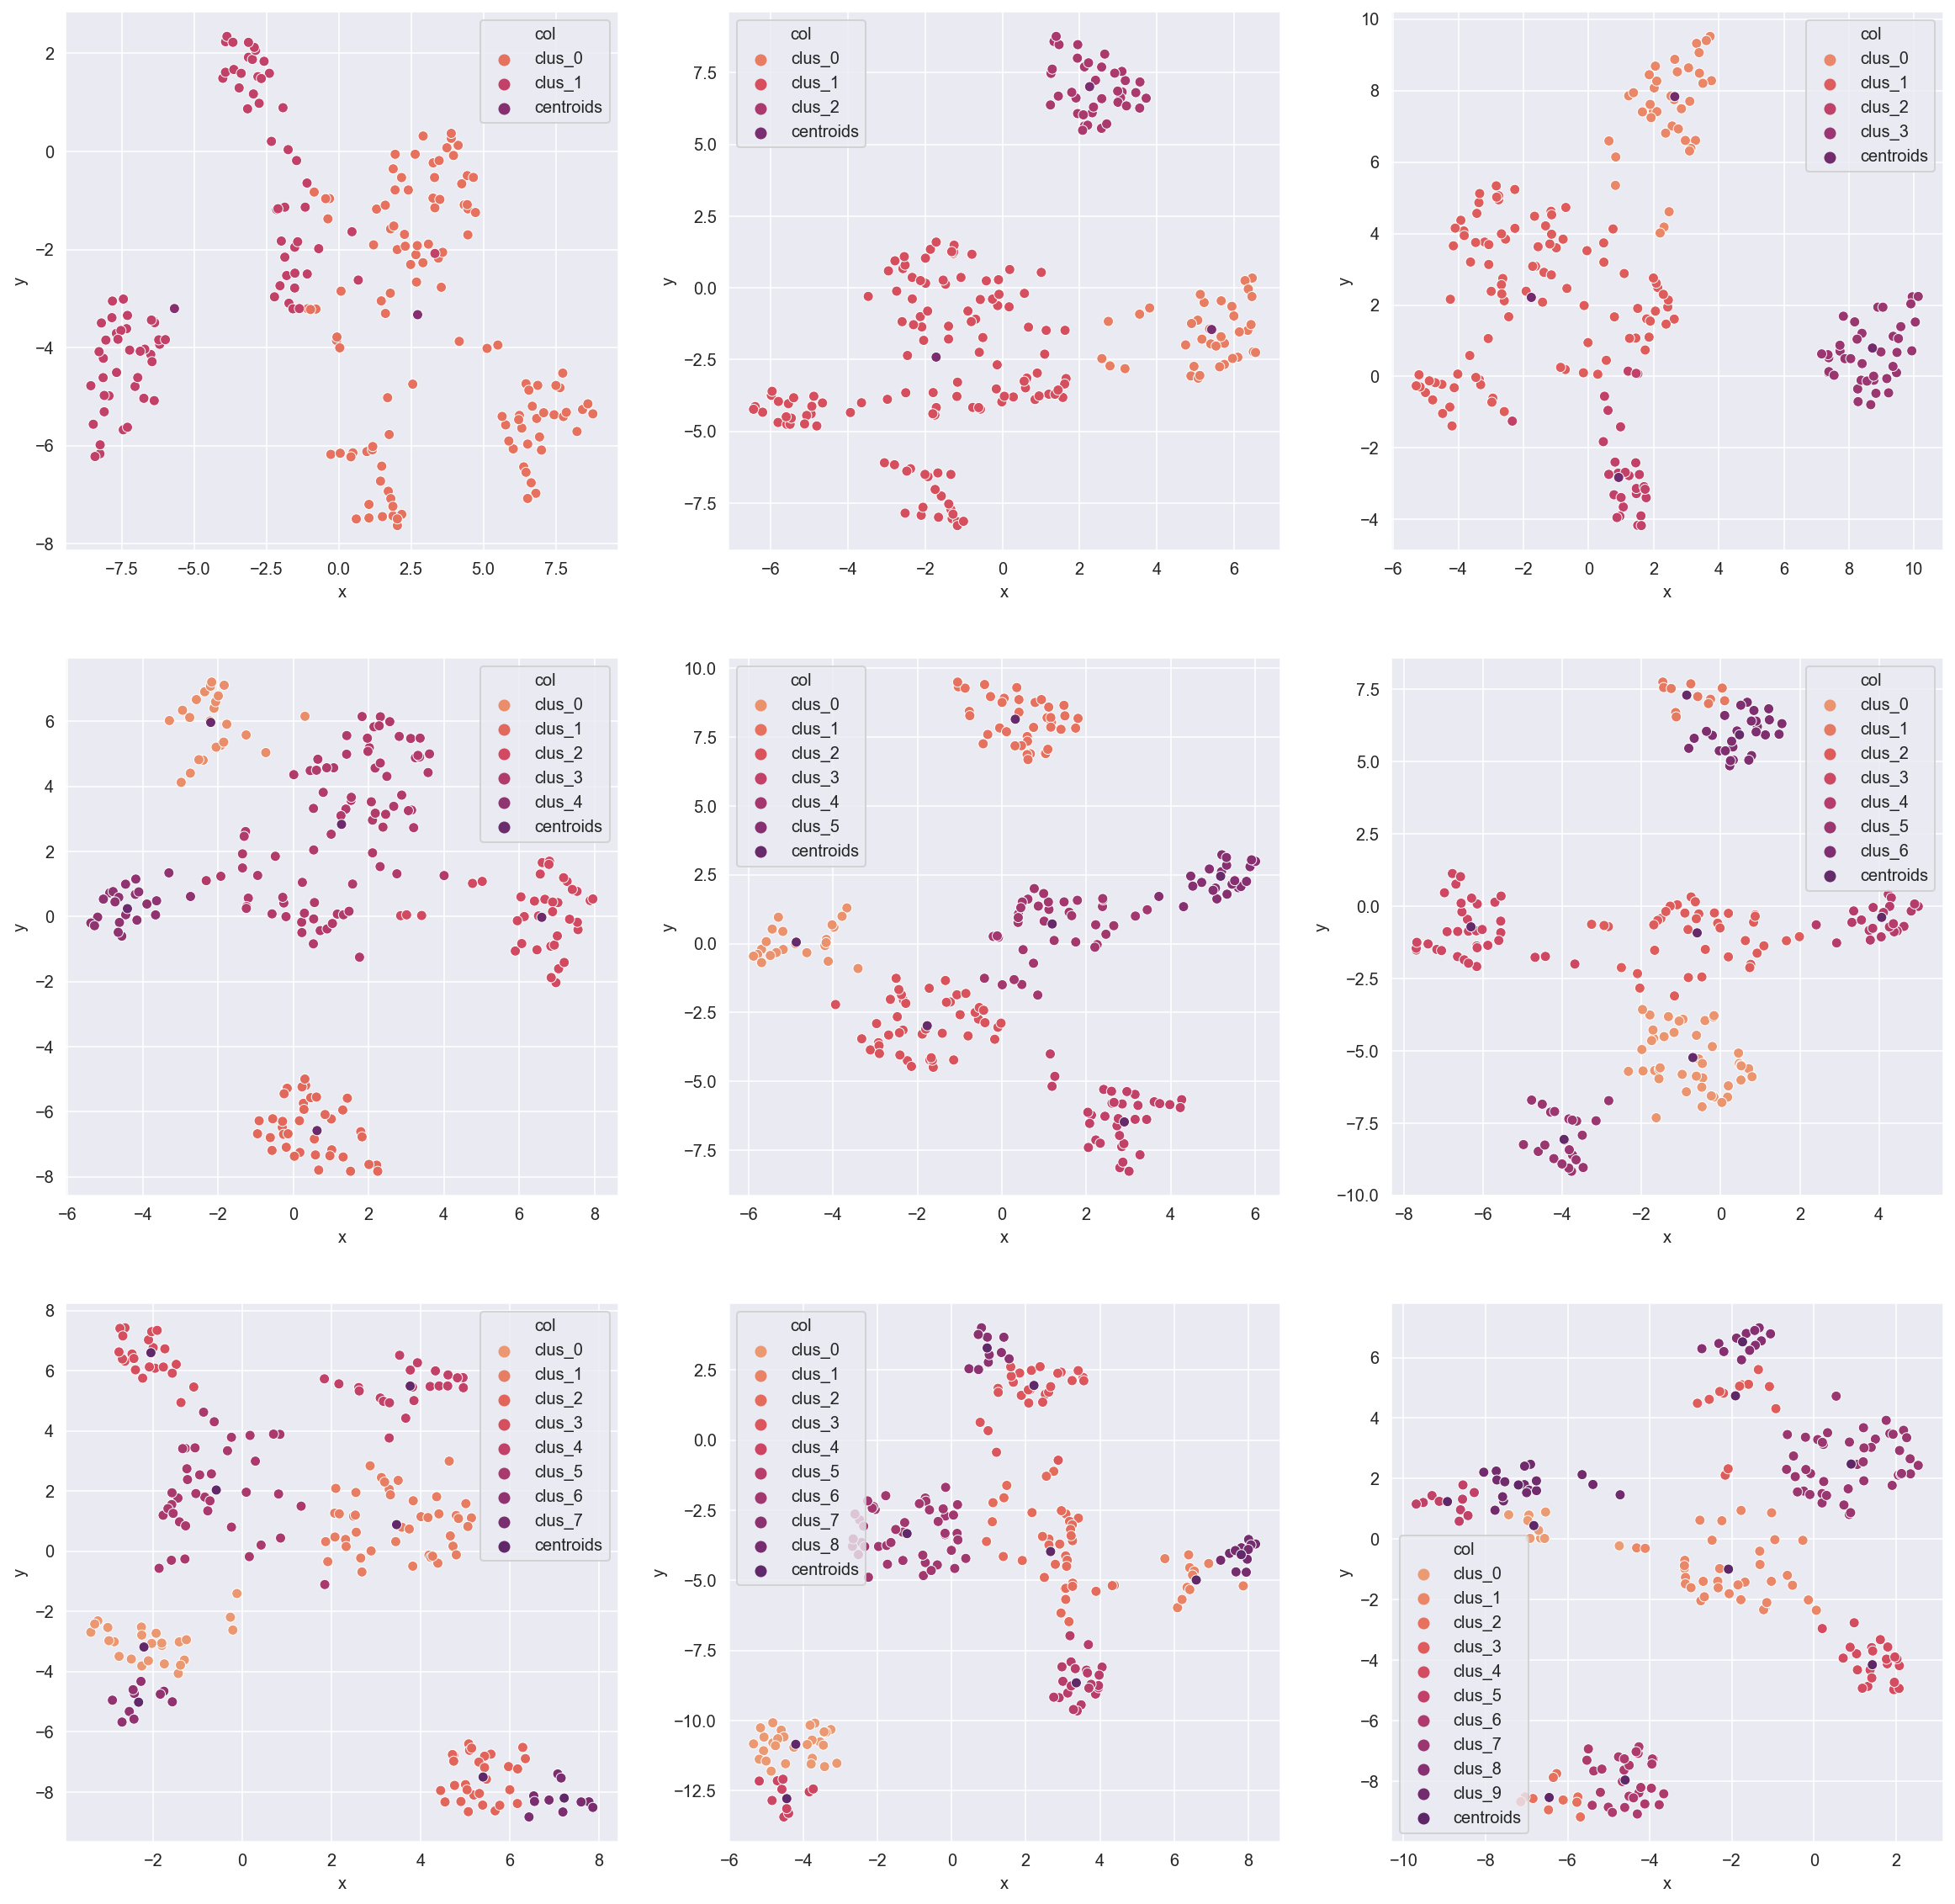

In [92]:
#Clustering with all features. We will define another custom function to plot results depending on the value of K.

from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, verbose=0, perplexity=50, n_iter= 4000)

inertia_all=[]
silhouette_all=[]
centroids_all=[]
label_all=[]

fig=plt.figure(figsize=(20,20));
for i in range (2,11):
    
    centroids, label, inertia, silhouette=KMeans_Clustering(df, i)
    df['label']=label
    df_order_by_label=df.sort_values(by='label', ascending=True)
    
    reduced_data=tsne.fit_transform(list(df_order_by_label.values.tolist()+centroids.tolist()))
    inertia_all.append(inertia)
    silhouette_all.append(silhouette)
    centroids_all.append(centroids)
    label_all.append(label)
    
    cols=[]
    for cluster_num in range(i):
        cols+=['clus_{}'.format(cluster_num)]*(list(label).count(cluster_num))
    for centroid in centroids:
        cols+=(['centroids'])
        
    X = {
    'x': reduced_data[:,0],
    'y': reduced_data[:,1],
    'col' : cols,
    }
    
    data = pd.DataFrame(data=X)
    markers=['o' for cluster_num in range(i)]
    markers.append('x')
    g=fig.add_subplot(3,3,i-1);
    f=sns.scatterplot(data=data, x='x', y='y', hue='col', palette='flare', markers=markers, ax=g);

####  Validation Functions

Let´s define some custom functions to validate the clustering model and choose the best number of clusters for our data. For doing so, we will use inertia and silhouette metrics that have been calculated during the training of the clustering model.

-Elbow Method: This method uses inertia values for determining the optimum number of clusters. As we have explained before, inertia is a measure that calculates the sum of squared distances of each data point to their nearest cluster centroid. So, the smaller the inertia inside a cluster, the better the cluster is.

-Silhouette coefficient: Compares the average distance between each point with all the rest inside its cluster with the average distance between each point and all the points in the closest cluster. The goal is to minimize the first measure and maximize the last one. So when this coefficient is closer to 1 indicates a better cluster.

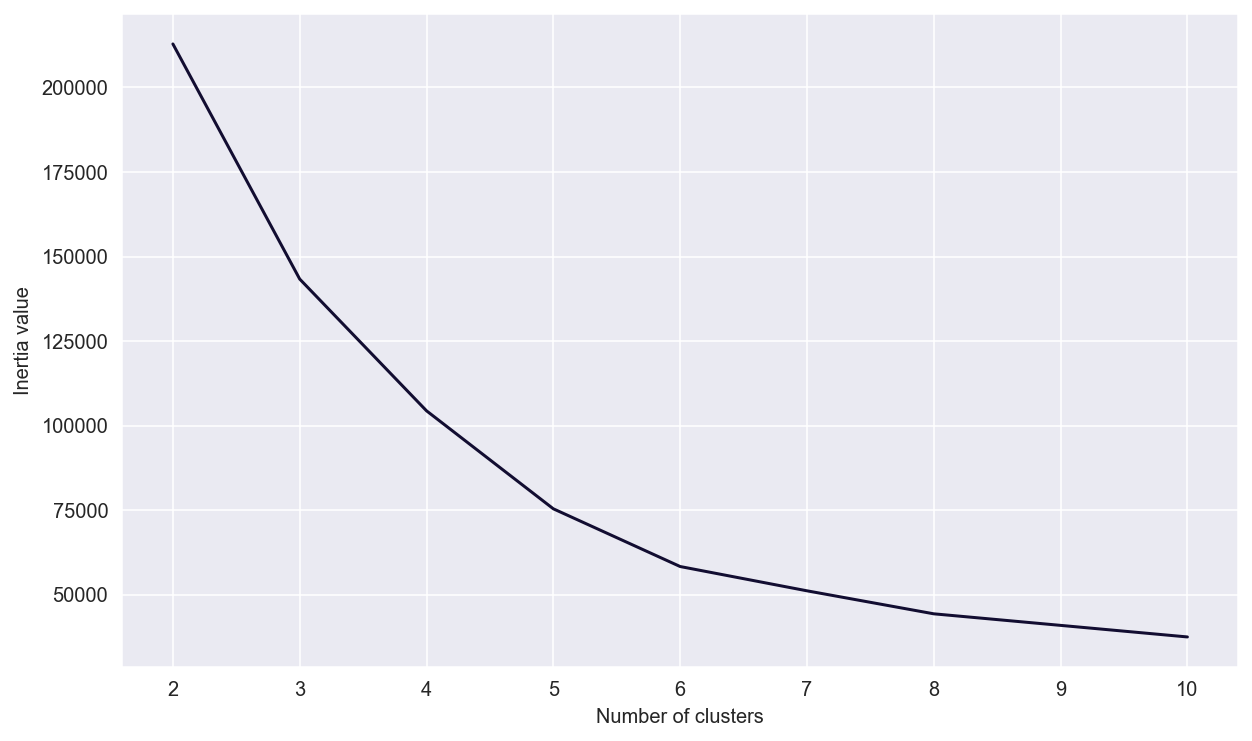

In [88]:
#Elbow Method: 

fig=plt.figure(figsize=(10,6))
plt.plot(np.arange(2,11), inertia_all)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia value');

We can see that above 6 clusters the improvement in inertia value is not very significative.

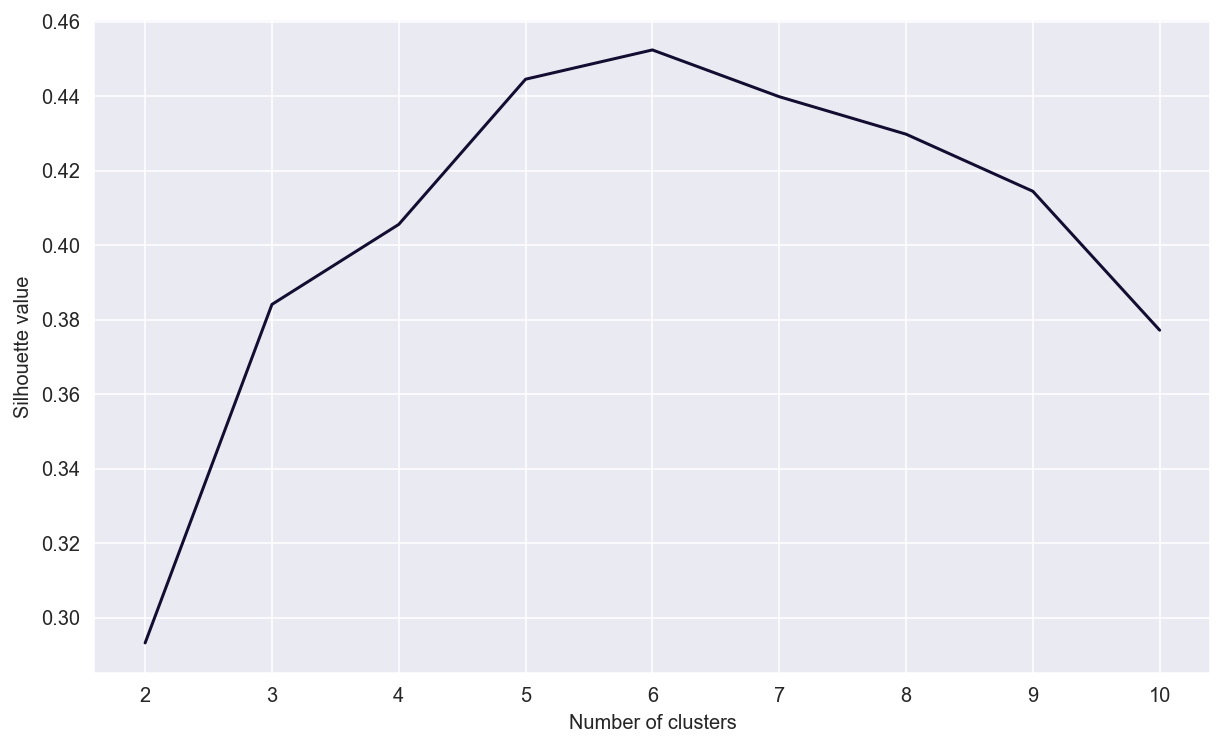

In [89]:
#Silhouette Method:

fig=plt.figure(figsize=(10,6))
plt.plot(np.arange(2,11), silhouette_all)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette value');

Also with this method 6 clusters seem to be the optimum number.

#### CLUSTERING FOR 'SPENDING SCORE' UNDERSTANDING

We have already analyzed the behaviour taking into account all the variables, but the goal is increase the 'Spending Score'. So now we are going to perform clustering analyzing the behaviour of each indepediente variable with respect to this feature.

##### Age of customers - Spending Score

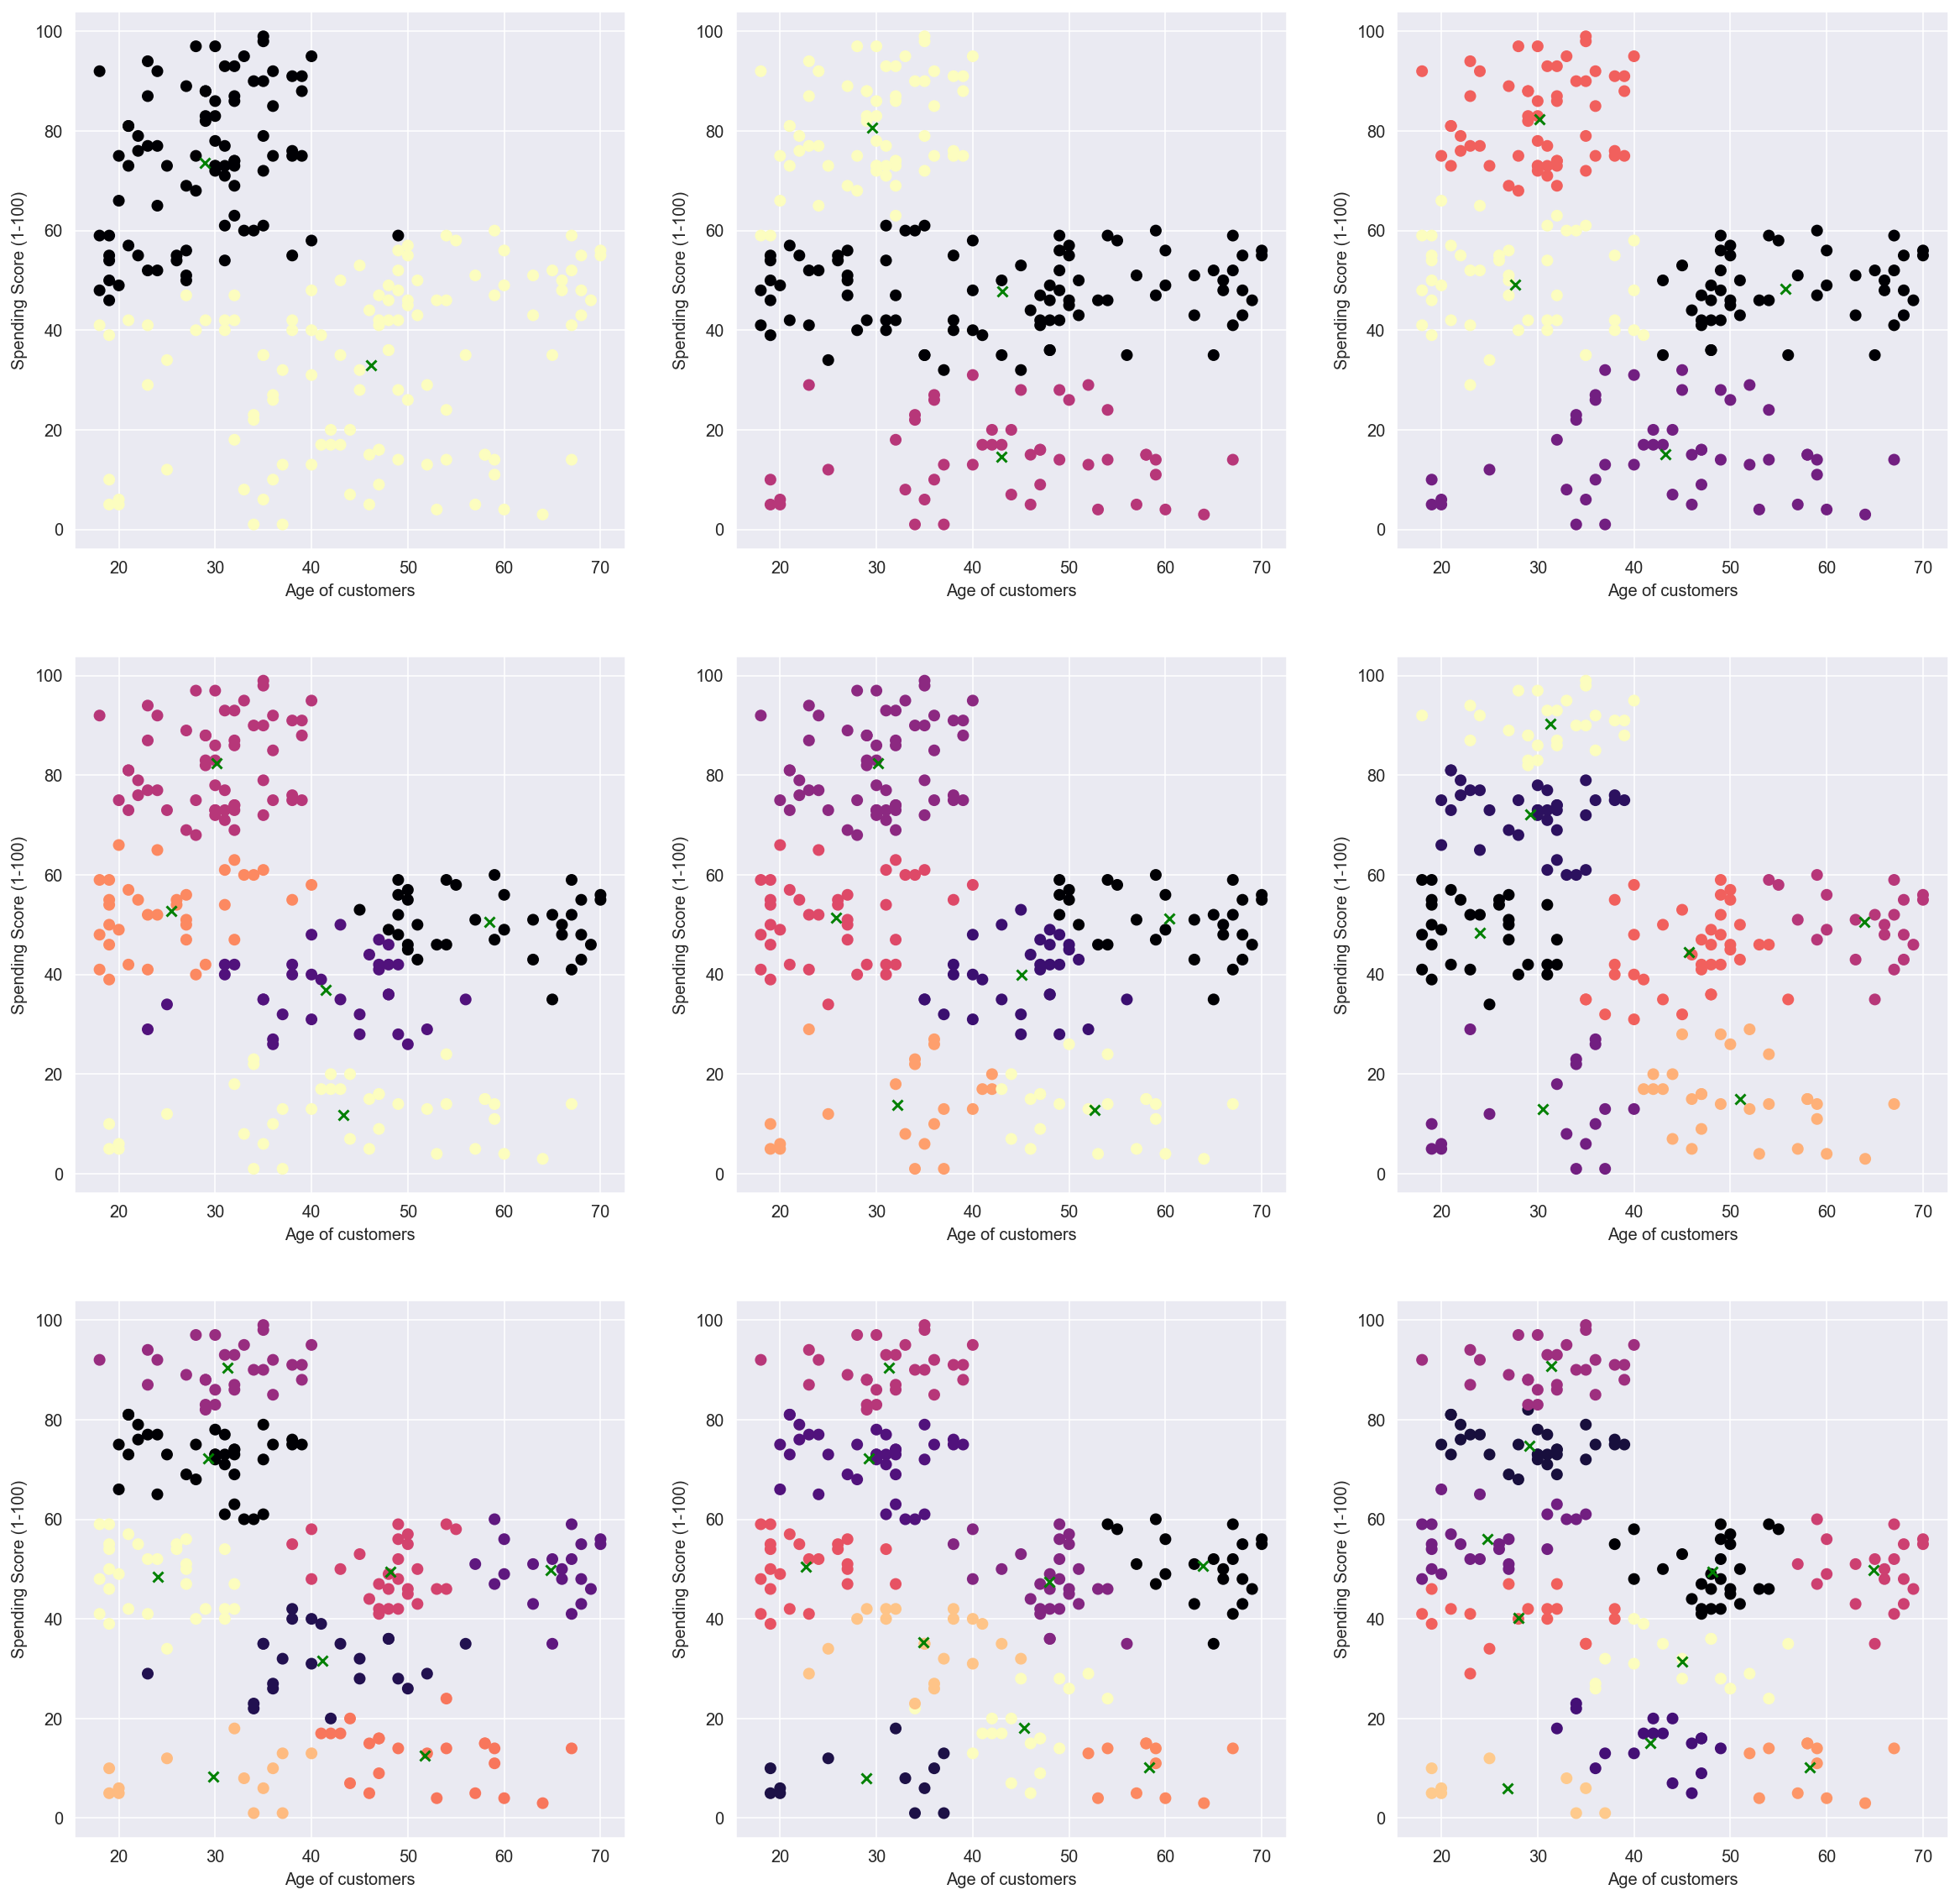

In [105]:
inertia_all=[]
silhouette_all=[]
centroids_all=[]
label_all=[]

fig=plt.figure(figsize=(20,20));
for i in range (2,11):
    
    centroids, label, inertia, silhouette=KMeans_Clustering(df[['Age','Spending Score (1-100)']], i)
    df['label']=label
    
    inertia_all.append(inertia)
    silhouette_all.append(silhouette)
    centroids_all.append(centroids)
    label_all.append(label)
    
    #We need to pass centroids to dataframe
    df_cent=pd.DataFrame(centroids, columns=['x','y'])
    
    
    g=fig.add_subplot(3,3,i-1)
    g=plt.scatter(df['Age'], df['Spending Score (1-100)'], cmap='magma', c=df['label'])
    g=plt.scatter(df_cent['x'], df_cent['y'], marker='x', color='g')
    g=plt.xlabel('Age of customers')
    g=plt.ylabel('Spending Score (1-100)');

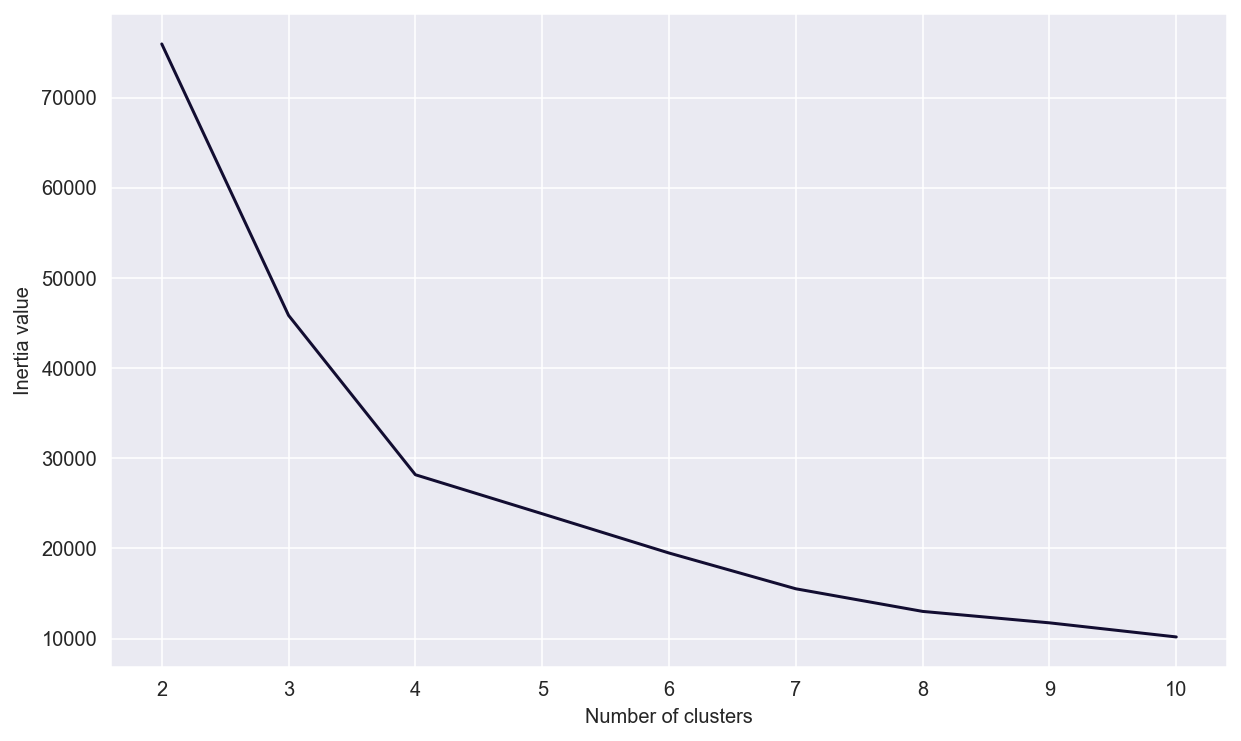

In [97]:
#Elbow method

fig=plt.figure(figsize=(10,6))
plt.plot(np.arange(2,11), inertia_all)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia value');

In this case the optimum number of clusters seems to be 4.

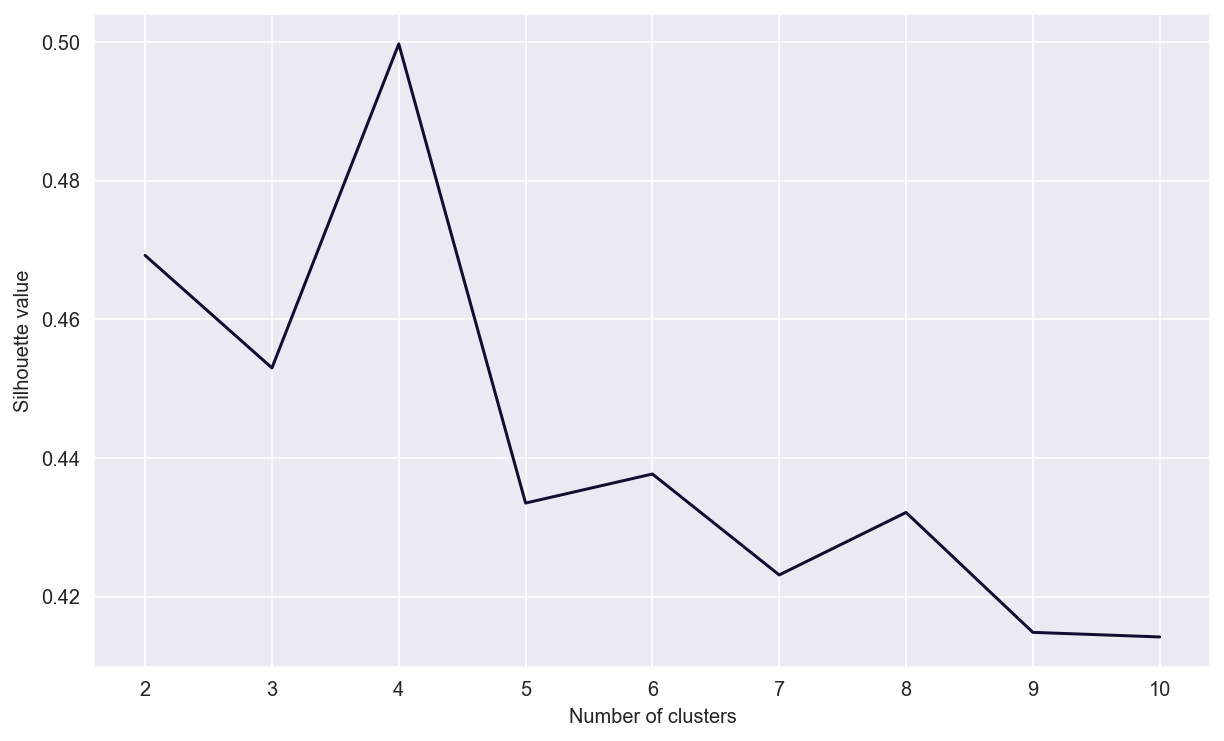

In [98]:
#Silhouette Method:

fig=plt.figure(figsize=(10,6))
plt.plot(np.arange(2,11), silhouette_all)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette value');

##### Annual Income of customers - Spending Score

Let´s make the same but now with Annual Income of customers.

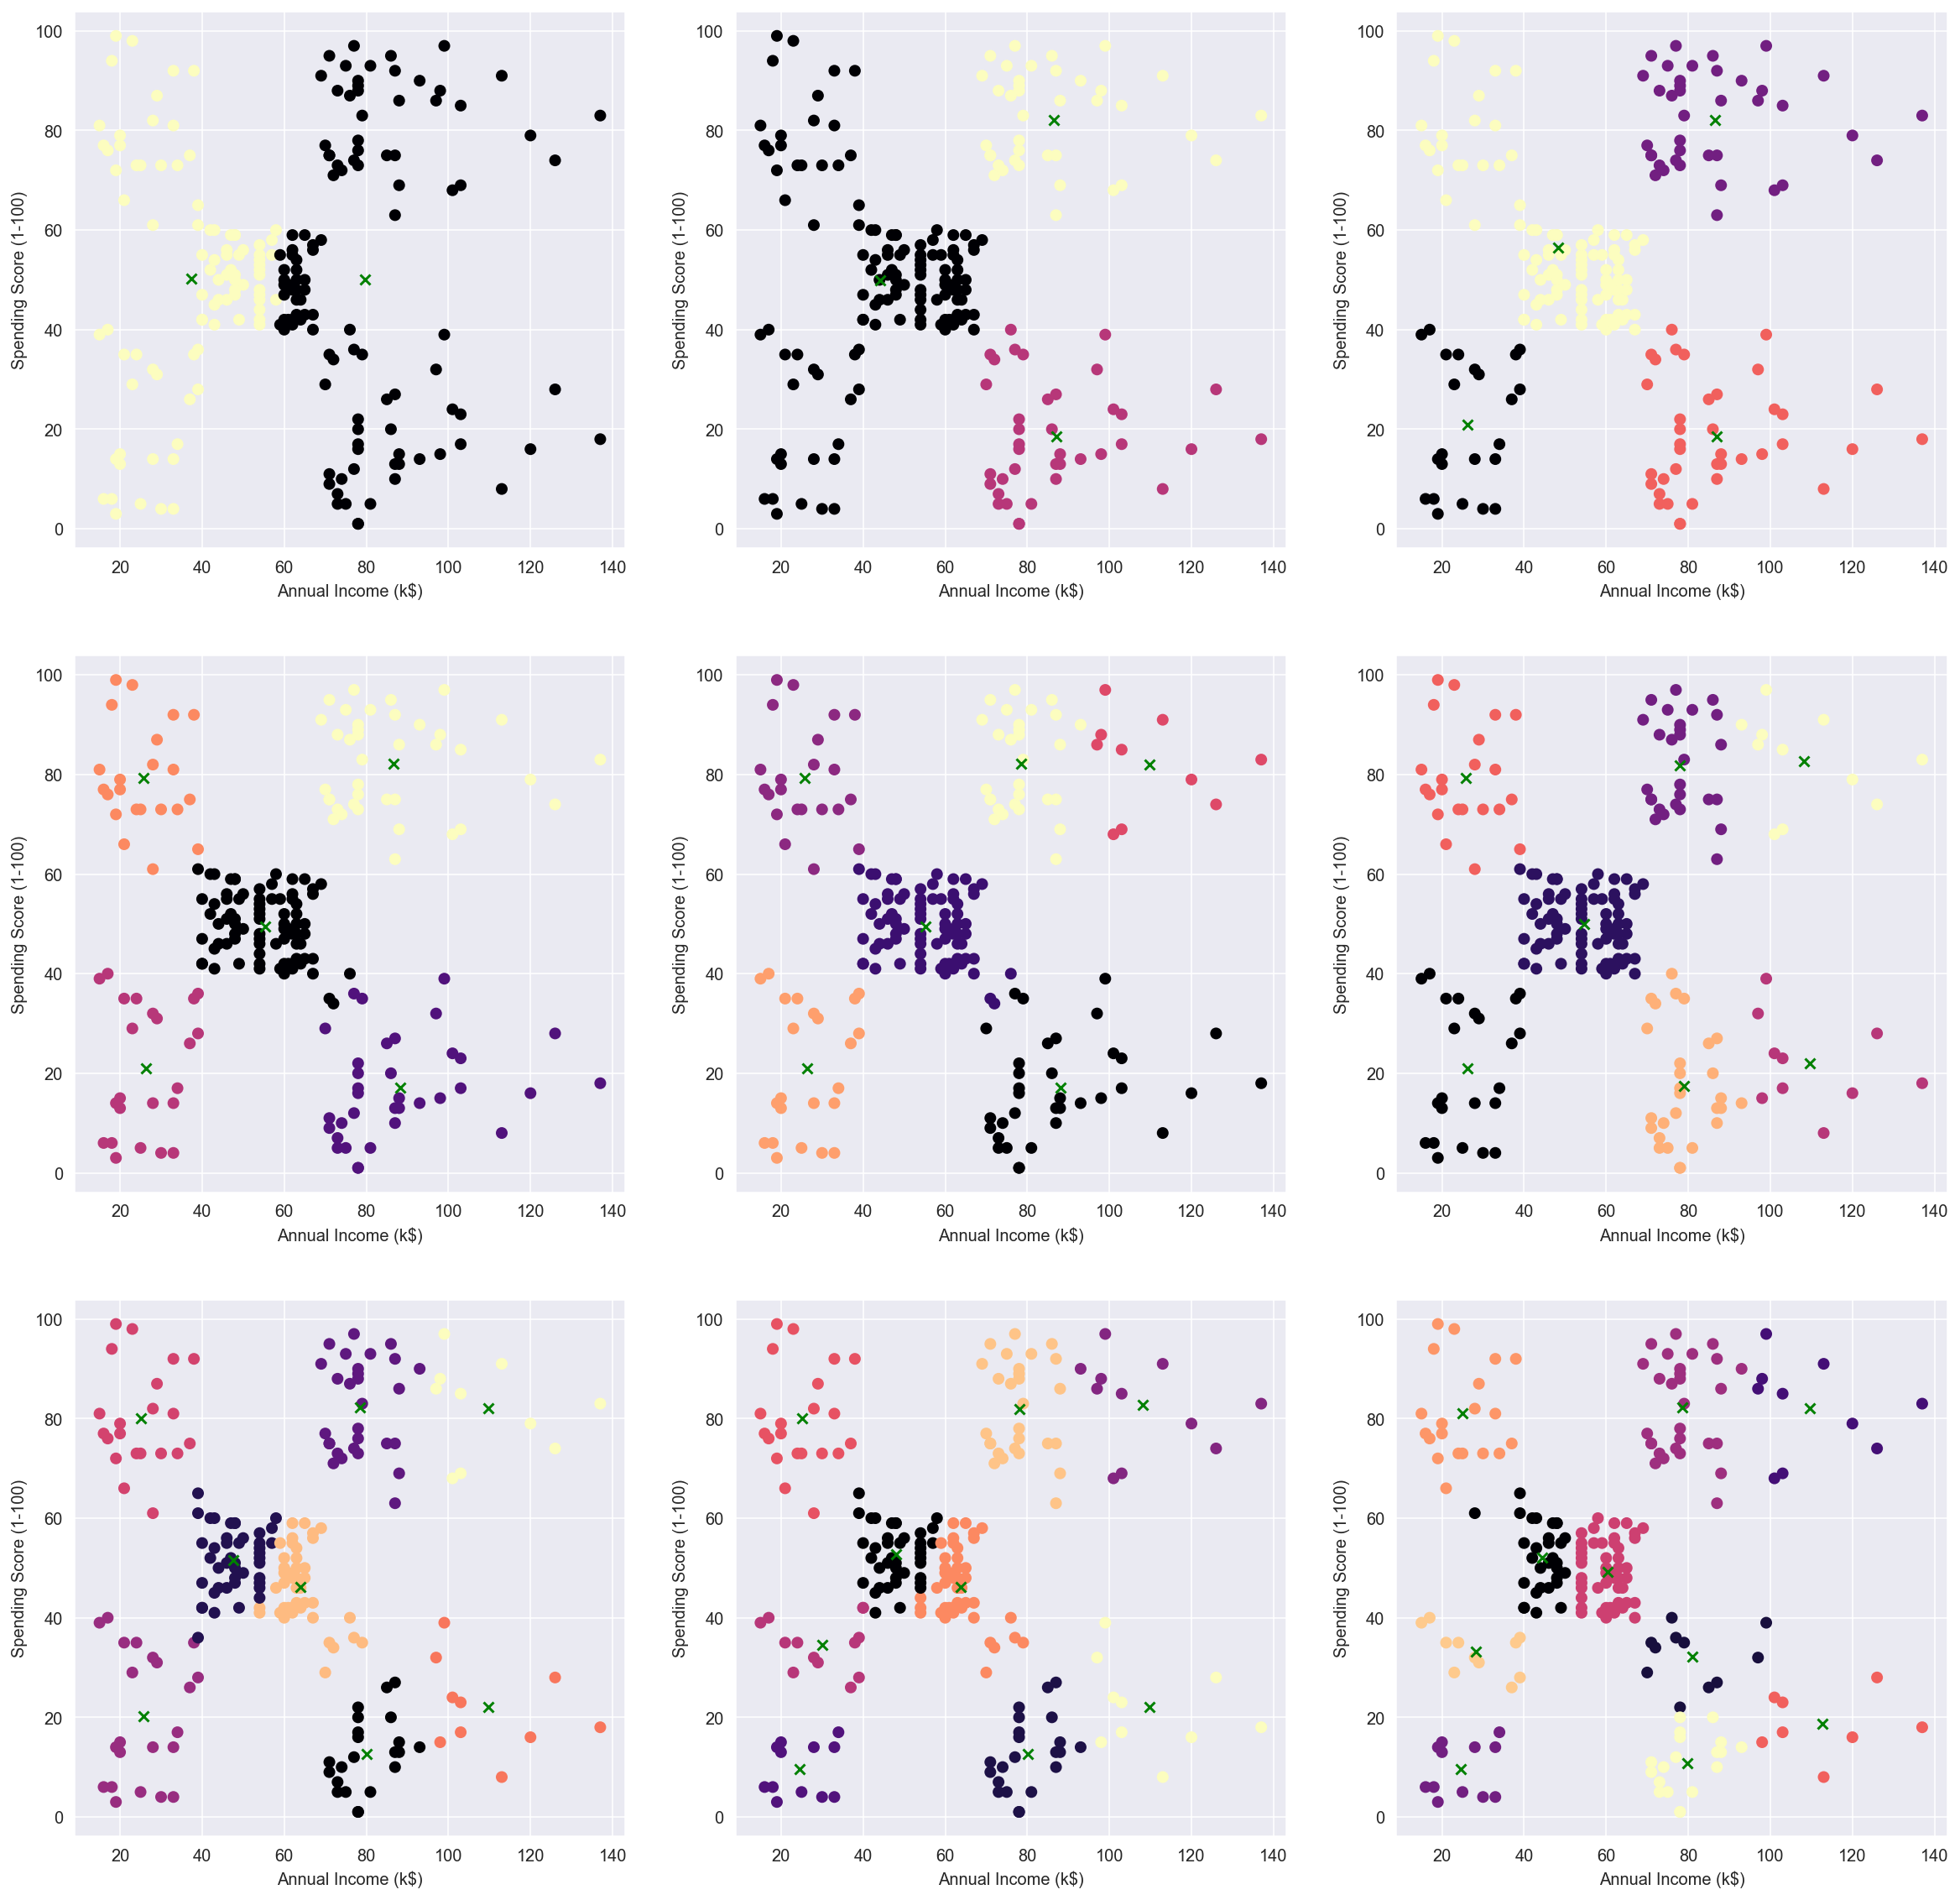

In [110]:
inertia_all=[]
silhouette_all=[]
centroids_all=[]
label_all=[]

fig=plt.figure(figsize=(20,20));
for i in range (2,11):
    
    centroids, label, inertia, silhouette=KMeans_Clustering(df[['Annual Income (k$)','Spending Score (1-100)']], i)
    df['label']=label
    
    inertia_all.append(inertia)
    silhouette_all.append(silhouette)
    centroids_all.append(centroids)
    label_all.append(label)
    
    #We need to pass centroids to dataframe
    df_cent=pd.DataFrame(centroids, columns=['x','y'])
    
    
    g=fig.add_subplot(3,3,i-1)
    g=plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], cmap='magma', c=df['label'])
    g=plt.scatter(df_cent['x'], df_cent['y'], marker='x', color='g')
    g=plt.xlabel('Annual Income (k$)')
    g=plt.ylabel('Spending Score (1-100)');

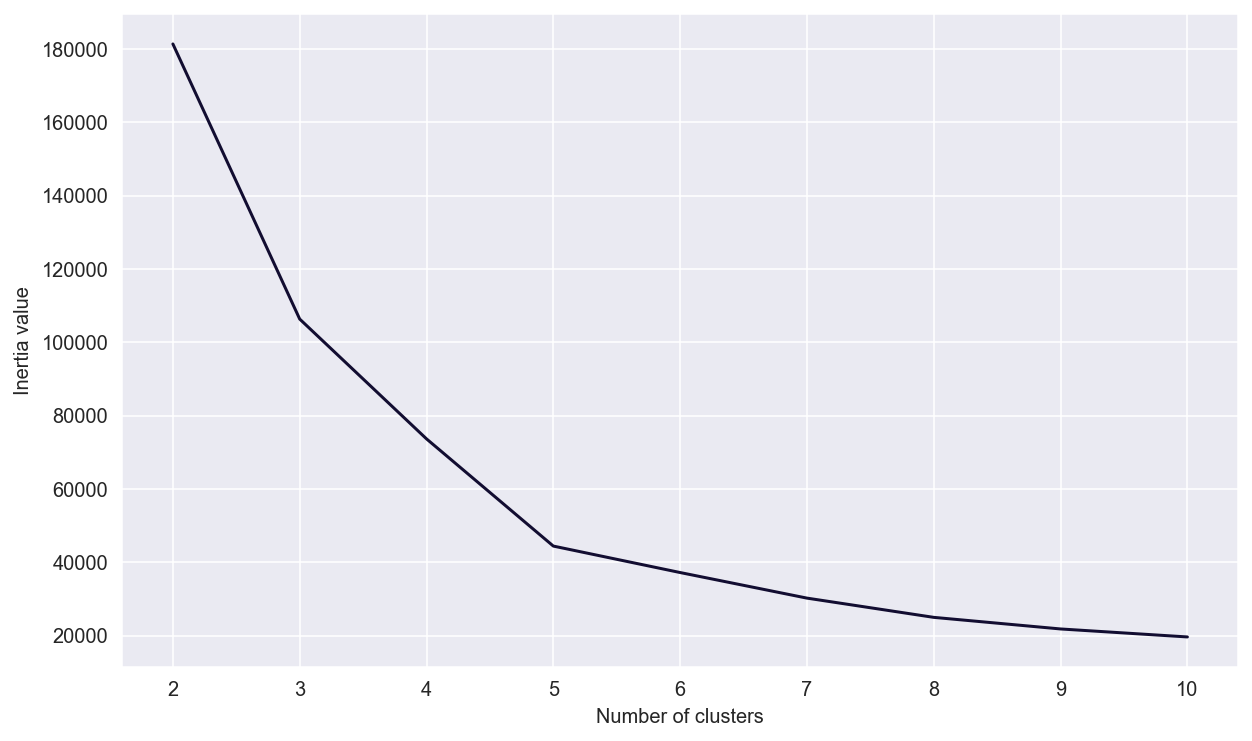

In [111]:
#Elbow method

fig=plt.figure(figsize=(10,6))
plt.plot(np.arange(2,11), inertia_all)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia value');

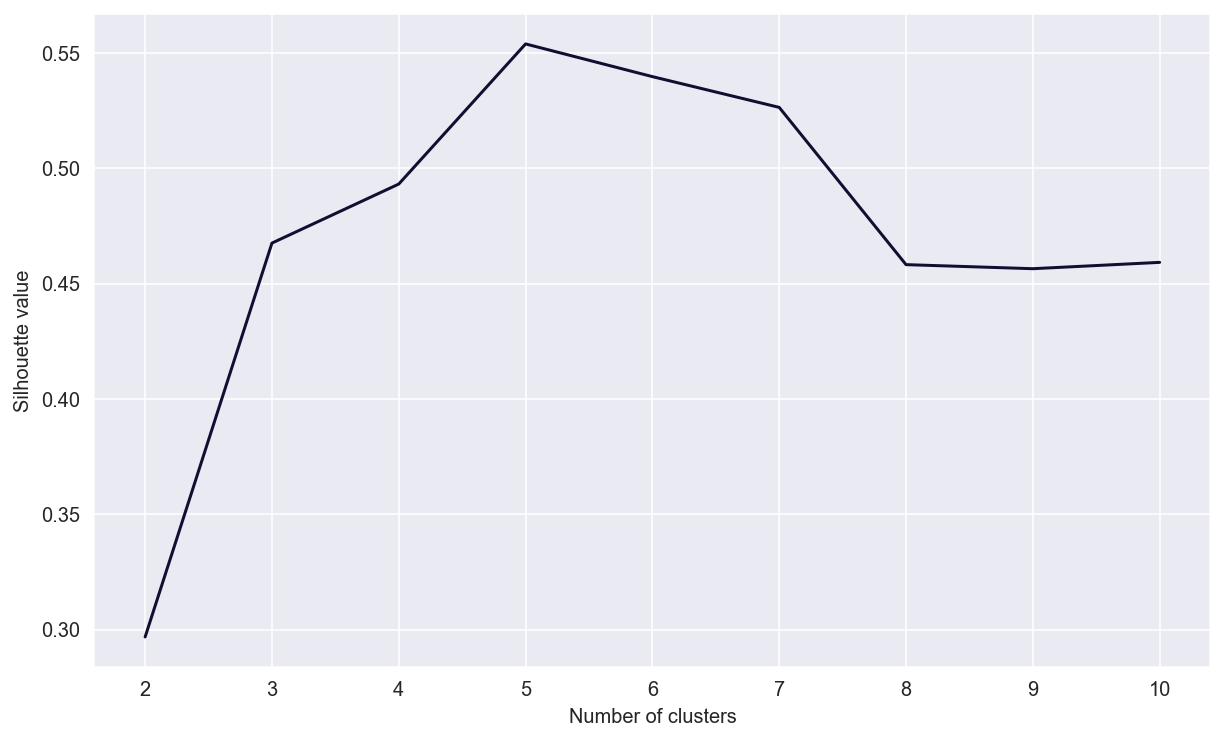

In [112]:
#Silhouette Method:

fig=plt.figure(figsize=(10,6))
plt.plot(np.arange(2,11), silhouette_all)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette value');

### CONCLUSIONS:

Some important conclusions we can make from the results obtained above are:

We can classify our customers into 5 different groups accordingly to the Annual Income of customers. These groups are:

  - Customers with Annual Income below 40k and a Spending Score above 60.
  - Customers with Annual Income below 40k and a Spending Score below 40.
  - Customers with Annual Income above 70k and a Spending Score below 40.
  - Customers with Annual Income above 70k and a Spending Score above 60.
  - Customers with Annual Income between 40k and 70k and a Spending Score between 40 and 60.
  
We can classify our customers into 4 different groups accordingly to the Age of customers. These groups are:

  - Customers with Age between 18 and 40 and a Spending Score above 70.
  - Customers with Age between 18 and 40 and a Spending Score between 30 and 70.
  - Customers with Age above 40 and a Spending Score between 35-60.
  - Customers with a Spending Score below 35 (of all ages).
  
 So, taking into account this groups we can develop different marketing strategies for these targets:
 
 -Marketing campaigns accordingly to the annual income level of the customer.
 -Discount programs for groups with the highest revenue (to retain customers, fidelity programs).
 -Different acquisition strategies for customers with low spending scores.
 -Also, young people have a mean score over 70, and we have another cluster with the same age range and a spending score below 70, we could think about strategies to improve this specific group.
  